# Model Formating Overview

This notebook was created to enable common formatting for the Early Release Science modeling initiatives. We will review: 

1. Variable terminology
2. File naming schemes 
3. Data formating 
4. Physical unit archiving 

This is namely for the booking of the following model types: 

1. 1D-3D climate (spatial- and/or altitude- dependent climate) 
2. 1D-3D chemistry (spatial- and/or altitude- dependent atmospheric composition) 
3. 1D-3D cloud (spatial- and/or altitude- dependent single scattering, asymmetries, cloud optical depth) 
4. Spectroscopy (flux, transit depth as a function of wavelength) 

However, it can be applied to other modeling products (e.g. mixing profiles).

## Variable Terminology 

All file names and meta data should conform to the following variable names. Note, that these will not apply to all models. This is just an initial list. Please shoot me a DM, or slack for additional parameters to add (natasha.e.batalha@nasa.gov, or ERS slack channel)

### Planet parameters (`planet_params`)

1. `tint`: object internal temperature
2. `heat_redis`: heat redistribution (only relevant for irradiated objects)
3. `rp`: planet radius
4. `mp`: planet mass 
5. `p_reference`: reference pressure radius 
6. `pteff`: planetary effective temperature 

### Stellar parameters (`stellar_params`)
1. `logg` : gravity
2. `feh` : stellar metallicity 
3. `steff` : stellar effective temperature 
4. `rs` : stellar radius 
5. `ms` : stellar mass

### Orbital parameters (`orbit_params`)
1. `sma` : semi-major axis 

### Atmospheric parameters (`atmo_params`)
1. `mh` : metallicity 
2. `cto` : carbon to oxygen ratio 
3. case sensitive molecule names (e.g. Na, H2O, TiO)
4. `temperature`: computed

### Cloud parameters (`cld_params`)
1. `opd` : extinction optical depth 
2. `ssa` : single scattering albedo
3. `asy` : asymmetry parameter

### Model Gridding 
1. `pressure`: pressure grid 
2. `wavelength`: wavelength grid 
3. `wno`: wavenumber grid 
4. `lat`: latitude grid 
5. `lon`: longitude grid

# Specifying units

We should be able to convert all units to `astropy.units`. For unitless parameters (e.g. single scattering albedo, optical depth) unitless designation should be provided. See example:



In [1]:
import astropy.units as u

In [2]:
#examples of valid units

u.Unit('cm') #Valid 
#u.Unit('CM') #NOT valid
u.Unit("R_jup")#Valid
u.Unit("R_jupiter")#Valid
#u.Unit("R_Jupiter")#NOT Valid

Unit("jupiterRad")

In [3]:
unit = 'cm'
#doing it this away enables easy conversions. for example: 
(1*u.Unit('R_jup')).to('cm')

<Quantity 7.1492e+09 cm>

# Data Types: Using `xarray`

[xarray: N-D labeled arrays and datasets in Python](https://docs.xarray.dev/en/stable/): From their website: "array introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures."

Xarray is your friend and will make it very easy for other folks to use your data. Let's build some simple examples.


### `attrs` in `xarray`

This is how we make sure we credit the appropriate people for their work, and understand the meta data surrounding the model runs. 

### Required

1. Author list 
2. point of contact 
3. code used (can be a dictionary. e.g. {'chemistry':'vulcan', 'cloud':'virga', 'spectra':'chimera'}

### Optional 
1. doi : made sure to include if you want your work referenced! 
2. planet_params (with keys defined in section 1) 
3. stellar_params
4. orbit_params
5. atmo_params


## Easy Example: 1D data: e.g. P-T profiles, chemistry

Here we will show an example with `pressure` as the dependent variable. Spectra, which are on a wavelength or wavenumber grid, can also be stored similarly.

In [4]:
import numpy as np
import xarray as xr
import json #we will use this to dump model parameters into an attribute

In [5]:
#fake pressure temperature profile at 1000 K
pressure = np.logspace(-6,2,50)
temperature = np.logspace(-6,2,50)*0 + 1000

Practice convert to `xarray`. In this case we are storing `temperature` data, labeled with `unit` "Kelvin" that is on a grid of `pressure` with units of "bar"

In [6]:
# put data into a dataset where each
ds = xr.Dataset(
    data_vars=dict(
        temperature=(["pressure"], temperature,{'units': 'Kelvin'})#, required
    ),
    coords=dict(
        pressure=(["pressure"], pressure,{'units': 'bar'})#required*
    ),
    attrs=dict(author="NE Batalha",#required
               contact="natasha.e.batalha@nasa.gov",#required
               code="numpy", #required
               doi="",#optional if there is a citation to reference
               planet_params=json.dumps({'rp':1, 'mp':1}), #optional in accordance with model runs
               stellar_params=json.dumps({'rs':1, 'ms':1}), #optional in accordance with model runs
              ),
)

In [7]:
#printing is easy
ds

<xarray.Dataset>
Dimensions:      (pressure: 50)
Coordinates:
  * pressure     (pressure) float64 1e-06 1.456e-06 2.121e-06 ... 68.66 100.0
Data variables:
    temperature  (pressure) float64 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
Attributes:
    author:          NE Batalha
    contact:         natasha.e.batalha@nasa.gov
    code:            numpy
    doi:             
    planet_params:   {"rp": 1, "mp": 1}
    stellar_params:  {"rs": 1, "ms": 1}

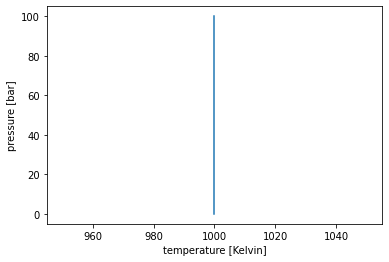

In [8]:
#plotting is easy
ds['temperature'].plot(y='pressure')

### Looping to add many variables to `data_vars`

If you have a big table of many parameters, e.g. molecules you can pre-make `data_vars` as a dictionary then add it like this:

In [9]:
fake_chemistry = {i:np.random.randn(len(pressure)) for i in ['H2O','CH4','CO2','CO',"H2S"]}

data_vars=dict(
        temperature=(["pressure"], temperature,{'units': 'Kelvin'})#, required
    )
for i in fake_chemistry.keys(): 
    data_vars[i] = ([i], fake_chemistry[i],{'units': 'v/v'})#volume mixing ratio units
    
# put data into a dataset where each
ds = xr.Dataset(
    data_vars=data_vars,
    coords=dict(
        pressure=(["pressure"], pressure,{'units': 'bar'})#required*
    ),
    attrs=dict(author="NE Batalha",#required
               contact="natasha.e.batalha@nasa.gov",#required
               code=json.dumps({'climate':"numpy","chemistry":'numpy'}), #required
               doi="",#optional if there is a citation to reference
               planet_params=json.dumps({'rp':1, 'mp':1}), #optional in accordance with model runs
               stellar_params=json.dumps({'rs':1, 'ms':1}), #optional in accordance with model runs
              ),
)

## 2D data: e.g. cloud profiles with pressure vs wavenumber

In [10]:
wno = np.linspace(10,10000,400)#fake wavenumber array
opd = np.zeros((len(pressure), len(wno))) + 1 
ssa = np.zeros((len(pressure), len(wno))) + 0.9
asy = np.zeros((len(pressure), len(wno))) + 0.8

# put data into a dataset where each
ds = xr.Dataset(
    #now data is a function of two dimensions
    data_vars=dict(opd=(["pressure","wno"], opd,{'units': 'unitless per layer'}),
                   ssa=(["pressure","wno"], ssa,{'units': 'unitless'}),
                   asy=(["pressure","wno"], asy,{'units': 'unitless'}),
                  ),
    coords=dict(
        pressure=(["pressure"], pressure,{'units': 'bar'}),#required
        wno=(["wno"], wno,{'units': 'cm**(-1)'})#required
    ),
    attrs=dict(author="NE Batalha",#required
               contact="natasha.e.batalha@nasa.gov",#required
               code='numpy', #required
               doi="",#optional if there is a citation to reference
               planet_params=json.dumps({'rp':1, 'mp':1}), #optional in accordance with model runs
               stellar_params=json.dumps({'rs':1, 'ms':1}), #optional in accordance with model runs
              ),
)

## 3D data: e.g. GCM pressure grid

`xarray` is incredibly useful for GCM work. [Here is an example of how `picaso` uses `xarray` and `xesfm` to do regridding and 3d calculations](https://natashabatalha.github.io/picaso/notebooks/9a_3DInputsWithPICASOandXarray.html). 

Here we'll just show how to create a 3D gridded dataset.

In [11]:
lat = np.linspace(-90,85,40)#fake latitude array
lon = np.linspace(-180,175,100)#fake latitude array
temperature_3d = np.random.randn(len(lat),len(lon),len(pressure))

# put data into a dataset where each
ds = xr.Dataset(
    #now data is a function of two dimensions
    data_vars=dict(temperature=(["lat","lon","pressure"],temperature_3d ,{'units': 'Kelvin'})
                  ),
    coords=dict(
        pressure=(["pressure"], pressure,{'units': 'bar'}),#required
        lat=(["lat"], lat,{'units': 'degree'}),#required
        lon=(["lon"], lon,{'units': 'degree'}),#required
    ),
    attrs=dict(author="NE Batalha",#required
               contact="natasha.e.batalha@nasa.gov",#required
               code='numpy', #required
               doi="",#optional if there is a citation to reference
               planet_params=json.dumps({'rp':1, 'mp':1}), #optional in accordance with model runs
               stellar_params=json.dumps({'rs':1, 'ms':1}) #optional in accordance with model runs
              ),
)

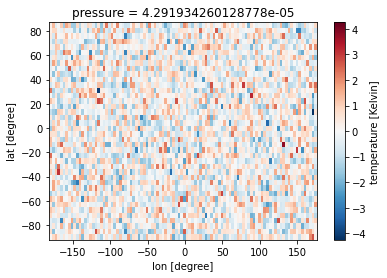

In [12]:
#easy plotting 
ds['temperature'].isel(pressure=10).plot()

# Storing `xarray` data 

## Filenaming

We usually rely on a long filename to give us information about the model. If we properly use `attrs` then filenaming does not matter. However, friendly filenames are always appreciated by people using your models. We suggest the following naming convention. 

Given independent variables (x,y,z): `tag_x{x}_y{y}_z{z}.nc`

For example: `jupiter_mh1_teff1000_tint100.nc`

## Using `netcdf`

"The recommended way to store xarray data structures is netCDF, which is a binary file format for self-described datasets that originated in the geosciences. Xarray is based on the netCDF data model, so netCDF files on disk directly correspond to Dataset objects (more accurately, a group in a netCDF file directly corresponds to a Dataset object. See Groups for more.)" - [Quoted from`xarray` website](https://docs.xarray.dev/en/stable/user-guide/io.html)

In [14]:
ds.to_netcdf("fakeplanet_1000teq.nc")

## Using `pickle`

In [16]:
import pickle as pk
pk.dump(ds, open("fakeplanet_1000teq.pk",'wb'))